# Final Project Submission

Please fill out:
* Student name: Joshua Brancazio
* Student pace: full time
* Instructor name: Rafael Carrasco
* Blog post URL: https://jbrancazio.github.io/hypothesis_testing

---
# Project 2 - The Northwind Database

## Method

For this project, I will start by obtaining my data and doing some quick exploratory work to understand how it is organized. I will then be using the scientific method to plan and organize my hypothesis testing. I will repeat this process for each of my 4 hypothesis. A brief summary of the method is below.


**1. Ask a Question**

I will find a question of interest to the shareholders and develop a null and alternate hypothesis. I will also define my level of significance at this stage.

**2. Do background research**

I will obtain the data needed to answer my question and format it as necessary to prepare it for my test. 

**3. Test with an experiment**

I will run the approproiate test and any post-hoc tests needed to answer my question

**4. Analize Data and Draw conclusions**

I will analyse the outcome, draw any conclusions and point out any further testing that might be needed or interesting.

------------

# Obtain The Data

My goal for this project is to test 4 hypothesis related to the Northwind Traders Co. database. Northwind Traders Co. is a fictional import/export company that sells specialty foods. The schema of this database is below and will be used throughout this process to inform my queries. 

<img src='Northwind_ERD.png'>

### Connecting to the database

I want to start out by creating my code to connect to the sql database and confirm that the schema above is accurate. I believe that is it good practice to double check and make sure that the schema is up to date.

I do this by creating a list of table names and printing the column information for each table. This is a great secondary referance to use as I create my queries moving forward. 

In [2]:
import sqlalchemy
import sqlite3
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

engine = create_engine('sqlite:///Northwind_small.sqlite',echo=True) #create connection to sql database
Session = sessionmaker(bind=engine)
session = Session()

inspector = inspect(engine)
con = engine.connect()

2019-01-31 22:13:22,884 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-01-31 22:13:22,890 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:22,893 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-01-31 22:13:22,895 INFO sqlalchemy.engine.base.Engine ()


In [3]:
table_names = inspector.get_table_names() # get tablle names from the Sql database
print(table_names)
for name in table_names:    
    print('Column names in table {}:'.format(name.upper()))
    print('\n',inspector.get_columns(name))
    print('\n')

2019-01-31 22:13:22,927 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-01-31 22:13:22,928 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']
Column names in table CATEGORY:
2019-01-31 22:13:22,935 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-01-31 22:13:22,936 INFO sqlalchemy.engine.base.Engine ()

 [{'name': 'Id', 'type': INTEGER(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'CategoryName', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Description', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


Column names in table CUSTOMER:
2019-01-31 22:13:22,942 INFO 

2019-01-31 22:13:22,999 INFO sqlalchemy.engine.base.Engine ()

 [{'name': 'Id', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'OrderId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ProductId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'UnitPrice', 'type': DECIMAL(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Quantity', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Discount', 'type': FLOAT(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


Column names in table PRODUCT:
2019-01-31 22:13:23,012 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-01-31 22:13:23,015 INFO sqlalchemy.engine.base.Engine ()

 [{'name': 'Id', 'type': INT

In [14]:
def Cohen_d(group1, group2): #define cohen d for effect size testing

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

After inspecting the column information, it seems that the schema is up to date.  

### Initial Exploration

The goal here is to get an idea of the data I will be using so that I can use that to inform the questions I will be exploring. The plan is to create some DataFrames that I can start to explore and use for testing. I will start by creating a dictionary of the tables that will allow me to explore more efficiently.

In [4]:
import pandas as pd 
df={} #import the database into pandas library for further exploration
for table_name in table_names:
    df[table_name] = pd.read_sql_query('''SELECT * FROM [{}]'''.format(table_name),con)

2019-01-31 22:13:26,785 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Category]
2019-01-31 22:13:26,787 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:26,806 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Customer]
2019-01-31 22:13:26,807 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:26,814 INFO sqlalchemy.engine.base.Engine SELECT * FROM [CustomerCustomerDemo]
2019-01-31 22:13:26,815 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:26,820 INFO sqlalchemy.engine.base.Engine SELECT * FROM [CustomerDemographic]
2019-01-31 22:13:26,821 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:26,825 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Employee]
2019-01-31 22:13:26,826 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:26,835 INFO sqlalchemy.engine.base.Engine SELECT * FROM [EmployeeTerritory]
2019-01-31 22:13:26,836 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:13:26,843 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-01-31 

In [5]:
for table_name in table_names: #print .info() too look for missing data
    print('.info() analysis for {}'.format(table_name))
    print('\n',df[table_name].info())
    print('\n')

.info() analysis for Category
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
Id              8 non-null int64
CategoryName    8 non-null object
Description     8 non-null object
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes

 None


.info() analysis for Customer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB

 None


.info() analysis for CustomerCustomerDemo
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
Id      

It seems there is no missing data so I can move on. 

The final preporation work I would like to do is create a total category that takes the number of products and multiplies it by the unit_price (with discount if appropriate) so that I can get a total sales value for orders. 

In [6]:
df['OrderDetail']['Total'] = df['OrderDetail']['Quantity'] * (df['OrderDetail']['UnitPrice']-(df['OrderDetail']['UnitPrice']*df['OrderDetail']['Discount']))
df['OrderDetail'].head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


The 4 questions I will be attempting to answer through my testing are:

>1. ***Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?***

>2. ***Looking for the top performers: Is the UK or US sales team sell more product? Are men or women more productive? Who is the top Sales Person?***

>3. ***Is there a difference in the mean number of products sold in a sales categories by region?***

>4. ***Is there a difference in the number of imports and domestic products that customers purchase and the revenue they create?***

-----
# Hypothesis 1

## 1. Ask a Question

The first question that I am trying to answer is the following:

>*Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?*

or

>*Is there a difference in the mean quantity of products sold between levels of discount?*

### Null Hypothesis:
**$H0: \mu_0  =  \mu_A$**

### Alternative Hypothesis:
**$HA: \mu_0  !=  \mu_A$**

I am interested in running two tests, the first bing a simple t-test that compares any discount to no discount. The second test I will run is a tukey test to determine if there is a difference between the levels of discounts. The significance value I will use is a value of p=0.05. 

## 2. Do Background Research

In [39]:
h1=pd.DataFrame(df['OrderDetail'][['Quantity','Discount']]) #create a dataframe of my data
print(h1.head())
print(h1['Discount'].value_counts()) 

   Quantity  Discount
0        12       0.0
1        10       0.0
2         5       0.0
3         9       0.0
4        40       0.0
0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64


In [40]:
bins_grade = ['0%', '5%', '10%','15%','20%', '25%'] #combine the discounts into this grouping
h1['Discount']= pd.cut(h1['Discount'],[0,0.001,0.05,0.1,0.15,0.20,0.25],labels=bins_grade)
h1['Discount'].replace(np.nan,'0%',inplace=True)
h1['Discount'].value_counts()

0%     1317
5%      192
10%     174
20%     161
15%     157
25%     154
Name: Discount, dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


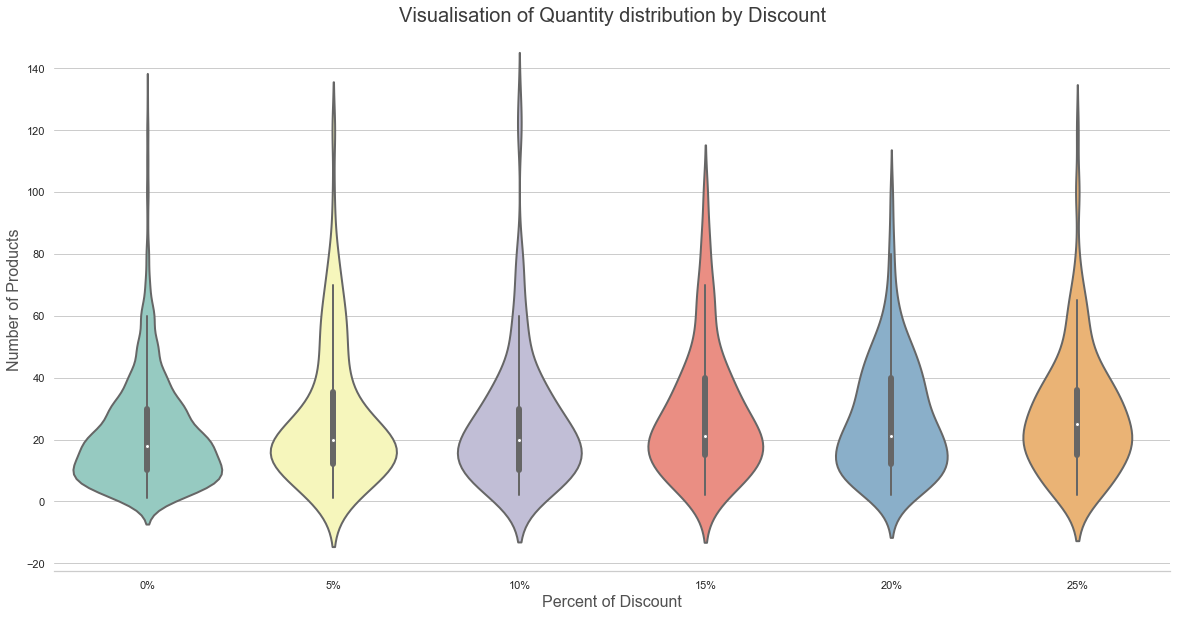

In [8]:
sns.set(style="whitegrid") # Create a violin plot to show distribution of data
f, ax = plt.subplots(figsize=(20, 10))


sns.violinplot(x="Discount",y="Quantity",data=h1, inner="box", palette="Set3", cut=2, linewidth=2)
sns.despine(left=True)

ax.set_title("Visualisation of Quantity distribution by Discount",size = 20,alpha=0.9)
ax.set_xlabel("Percent of Discount",size = 16,alpha=0.8)
ax.set_ylabel("Number of Products",size = 16,alpha=0.8)

plt.show()


In [56]:
#create my two groups for t-test
d_0=con.execute('''SELECT quantity FROM orderdetail WHERE discount = 0.''').fetchall()
d_any=con.execute('''SELECT quantity FROM orderdetail WHERE discount > 0.''').fetchall()

2019-01-31 22:26:49,940 INFO sqlalchemy.engine.base.Engine SELECT quantity FROM orderdetail WHERE discount = 0.
2019-01-31 22:26:49,942 INFO sqlalchemy.engine.base.Engine ()
2019-01-31 22:26:49,948 INFO sqlalchemy.engine.base.Engine SELECT quantity FROM orderdetail WHERE discount > 0.
2019-01-31 22:26:49,949 INFO sqlalchemy.engine.base.Engine ()


In [57]:
#print statitics to look at sample size and variance differences
print('Statistics for zero discounts:')
print('Sample Size: ',len(d_0))
print('Mean: ',np.mean(d_0))
print('Variance: ',np.var(d_0))
print('\n')
print('Statistics for any discount:')
print('Sample Size: ',len(d_any))
print('Mean: ',np.mean(d_any))
print('Variance: ',np.var(d_any))


# Levene Test for testing homogeneity of variances
from scipy import stats
stats.levene(d_0, d_any)

Statistics for zero discounts:
Sample Size:  1317
Mean:  21.715261958997722
Variance:  306.2795924332757


Statistics for any discount:
Sample Size:  838
Mean:  27.10978520286396
Variance:  430.93782787748984


LeveneResult(statistic=array([14.8326717]), pvalue=array([0.00012091]))

## 3. Test with an Experiment

There are a few assumption we need to make in order to be able to compare the means:

1. **Data is independent**

We can assume the data is independant because we are working with individual products and discounts. 

2. **Data is collected randomly**

We can assume random data.

3. **The data is approximately normally distributed**

Base on the violin graph about the data seems to be approximately normally distributed. 

4. **Data sample size and variance are similar**

The sample sizes seem to vary and the results from the levene test show that we can not assume homogeniety of the variance. Because of this, we will have to use a Welch's t-Test to compare the means.

### Test 1

In [64]:
print(stats.ttest_ind(d_0,d_any,equal_var=False)) #equal_var=False runs a Welch's t-Test
print("Cohen's d: ",Cohen_d(np.array(d_0),np.array(d_any)))

Ttest_indResult(statistic=array([-6.23906914]), pvalue=array([5.65641429e-10]))
Cohen's d:  -0.28641058366376676


### Test 2

In [12]:
mc = MultiComparison(h1['Quantity'], h1['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0%    10%    3.3882  -0.9479  7.7243 False 
  0%    15%    6.6669   2.1282 11.2056  True 
  0%    20%    5.3096   0.8215  9.7977  True 
  0%    25%    6.525    1.9469 11.1031  True 
  0%     5%    5.3368   1.1841  9.4895  True 
 10%    15%    3.2787  -2.6385  9.196  False 
 10%    20%    1.9214  -3.9571  7.7999 False 
 10%    25%    3.1368  -2.8106  9.0843 False 
 10%     5%    1.9486  -3.6779  7.5752 False 
 15%    20%   -1.3573  -7.3868  4.6722 False 
 15%    25%   -0.1419  -6.2387  5.9549 False 
 15%     5%   -1.3301  -7.1143  4.4541 False 
 20%    25%    1.2154  -4.8437  7.2746 False 
 20%     5%    0.0272  -5.7173  5.7718 False 
 25%     5%   -1.1882  -7.0033  4.6269 False 
---------------------------------------------
['0%' '10%' '15%' '20%' '25%' '5%']


## 4. Analize Data and Draw conclusions

**Discounts sell more products!**

- Using Welch's t-test, we can see that there is a significant difference between the mean products sold when there was no discount offered (21.7) and any amount of discount offered (27.1). **$t= -6.23, p= 5.65641429e-10$**

- Using a tukey test, we can further explore that 15% , 20%, and 25% means are significantly different from the mean products sold with no discounts. 

- 5% discount is significantly different from 0 but 10% is not, while more data could clear up this difference, sticking with a discount of 15% or more will increase the number of items sold. 

- There is no significant difference between the groups of discount levels. 

Based on this analysis, I would suggest that if you would like to move more product, you offer a discount of 15%. This will both maximize your products sold as well as your profit. 

----
# Hypothesis 2


## 1. Ask a Question

The first question that I am trying to answer is the following:

>*Is the UK or US sales team sell more product? Are men or women more productive? Who is the top Sales Person?*

or

>*Is there a significant difference in the mean sales between the US and UK team? Men and Women? Is there a statistically significant top sales person?*

### Null Hypothesis:
**$H0: \mu_0  =  \mu_A$**

### Alternative Hypothesis:
**$HA: \mu_0  !=  \mu_A$**

I am interested in running three tests, the first bing a 2-tailed t-test that compares the US vs UK sales teams. The second test I will run is a tukey test to determine if there is a difference between the actual sales representatives. Finally I will run a 2-tailed t-test to see if there is a difference between sexes or the sales team. The significance value I will use is a value of p=0.05. 

## 2. Do Background Research

In [9]:
df['Order'].groupby('EmployeeId').count()# number of orders for each employee

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
EmployeeId,,,,,,,,,,,,,
1,123,123,123,123,120,123,123,123,123,123,123,122,123
2,96,96,96,96,93,96,96,96,96,96,96,93,96
3,127,127,127,127,127,127,127,127,127,127,127,122,127
4,156,156,156,156,151,156,156,156,156,156,156,155,156
5,42,42,42,42,42,42,42,42,42,42,42,42,42
6,67,67,67,67,65,67,67,67,67,67,67,64,67
7,72,72,72,72,69,72,72,72,72,72,72,70,72
8,104,104,104,104,100,104,104,104,104,104,104,103,104
9,43,43,43,43,42,43,43,43,43,43,43,40,43


In [10]:
h2 = pd.read_sql_query('''SELECT e.Id employee_id, e.TitleOfCourtesy sex, e.Region region, 
                            o.Id order_id,
                            od.UnitPrice unit_price, od.quantity quantity, od. discount discount
                            FROM OrderDetail od 
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            ;''', con)
h2.replace({'Ms.':'F','Mrs.':'F','Mr.':'M','Dr.':'M'},inplace=True)
h2['Total'] = h2['quantity'] * (h2['unit_price']-(h2['unit_price']*h2['discount']))
h2 = h2.groupby(['region','sex','employee_id','order_id'],as_index=False).sum()
h2.head()

2019-01-31 22:13:47,327 INFO sqlalchemy.engine.base.Engine SELECT e.Id employee_id, e.TitleOfCourtesy sex, e.Region region, 
                            o.Id order_id,
                            od.UnitPrice unit_price, od.quantity quantity, od. discount discount
                            FROM OrderDetail od 
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            ;
2019-01-31 22:13:47,329 INFO sqlalchemy.engine.base.Engine ()


,region,sex,employee_id,order_id,unit_price,quantity,discount,Total
0,British Isles,F,9,10255,88.3,110,0.00,2490.500
1,British Isles,F,9,10263,46.2,184,0.75,1873.800
2,British Isles,F,9,10324,117.0,241,0.60,5275.715
3,British Isles,F,9,10331,5.9,15,0.00,88.500
4,British Isles,F,9,10386,14.8,25,0.00,166.000


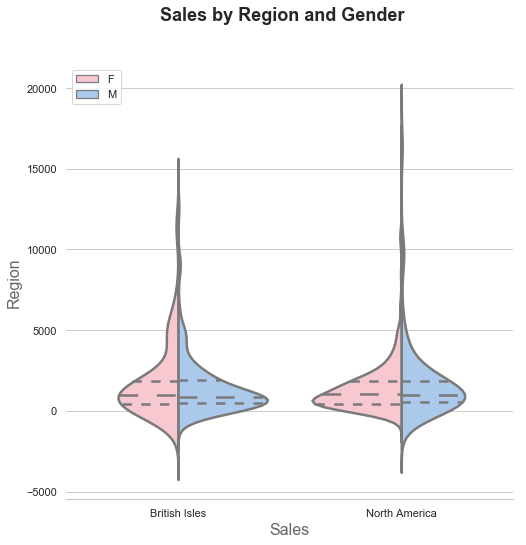

In [11]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

f, ax = plt.subplots(figsize=(8, 8))

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="region", y="Total", hue="sex", data=h2, cut=4, split=True, linewidth=2.5,
               inner="quart", palette={"M": "b", "F": "pink"})
sns.despine(left=True)

f.suptitle('Sales by Region and Gender', fontsize=18, fontweight='bold')
ax.set_xlabel("Sales",size = 16,alpha=0.7)
ax.set_ylabel("Region",size = 16,alpha=0.7)
plt.legend(loc='upper left')

In [12]:
british_isles_sales = h2['Total'].loc[h2['region'] == 'British Isles']
north_america_sales = h2['Total'].loc[h2['region'] == 'North America']

print('Statistics for British Isles:')
print('Sample Size: ',len(british_isles_sales))
print('Mean: ',np.mean(british_isles_sales))
print('Variance: ',np.var(british_isles_sales))
print('\n')
print('Statistics for any discount:')
print('Sample Size: ',len(north_america_sales))
print('Mean: ',np.mean(north_america_sales))
print('Variance: ',np.var(north_america_sales))

# Levene Test for testing homogeneity of variances
from scipy import stats
stats.levene(british_isles_sales, north_america_sales)

Statistics for British Isles:
Sample Size:  224
Mean:  1538.311220982143
Variance:  3564683.0850158446


Statistics for any discount:
Sample Size:  606
Mean:  1520.150702970298
Variance:  3339835.1899790205


LeveneResult(statistic=0.22981033874756163, pvalue=0.6317910824369707)

In [13]:
female_sales = h2['Total'].loc[h2['sex'] == 'F']
male_sales = h2['Total'].loc[h2['sex'] == 'M']

print('Statistics for Female:')
print('Sample Size: ',len(female_sales))
print('Mean: ',np.mean(female_sales))
print('Variance: ',np.var(female_sales))
print('\n')
print('Statistics for Male:')
print('Sample Size: ',len(male_sales))
print('Mean: ',np.mean(male_sales))
print('Variance: ',np.var(male_sales))



# Levene Test for testing homogeneity of variances
from scipy import stats
stats.levene(female_sales,male_sales)

Statistics for Female:
Sample Size:  553
Mean:  1504.4875904159142
Variance:  3055407.1350295474


Statistics for Male:
Sample Size:  277
Mean:  1566.1061444043312
Variance:  4087155.958365988


LeveneResult(statistic=0.42052384576704555, pvalue=0.5168555686649381)

## 3. Test with an Experiment

There are a few assumption we need to make in order to be able to compare the means:

1. **Data is independent**

We can assume the data is independant because we are working with individual products and discounts. 

2. **Data is collected randomly**

We can assume random data.

3. **The data is approximately normally distributed**

Base on the violin graph about the data seems to be approximately normally distributed. 

4. **Data sample size and variance are similar**

Based on the levene test above we can assume homogeneity of variance.

### Test 1

In [62]:
print(stats.ttest_ind(british_isles_sales,north_america_sales)) #T-test between regions
print("Cohen's d: ",Cohen_d(british_isles_sales,north_america_sales)) #regional Cohen's d

Ttest_indResult(statistic=0.1257920376990191, pvalue=0.8999270811672749)
Cohen's d:  0.009836113809944095


### Test 2

In [63]:
print(stats.ttest_ind(male_sales,female_sales)) #t-Test between sexes
print("Cohen's d: ",Cohen_d(female_sales,male_sales)) #sex Cohen's d

Ttest_indResult(statistic=0.45344886460688966, pvalue=0.6503443688380031)
Cohen's d:  -0.03337630667227915


### Test 3

In [22]:
mc2 = MultiComparison(h2['Total'], h2['employee_id']) #tukey test between employees
result2 = mc2.tukeyhsd()
 
print(result2)
print(mc2.groupsunique)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower      upper   reject
---------------------------------------------------
  1      2     172.9178  -607.717   953.5527 False 
  1      3     35.1011  -690.0519   760.2541 False 
  1      4     -68.9604 -760.1565   622.2357 False 
  1      5      76.061  -948.3608  1100.4829 False 
  1      6    -458.6694 -1329.0334  411.6946 False 
  1      7     168.2639  -682.311  1018.8388 False 
  1      8    -342.0209 -1105.6065  421.5648 False 
  1      9     236.0116 -779.4917  1251.5148 False 
  2      3    -137.8168  -913.044   637.4105 False 
  2      4    -241.8782 -985.4389   501.6824 False 
  2      5     -96.8568 -1157.3145  963.6009 False 
  2      6    -631.5872 -1544.0914  280.9169 False 
  2      7     -4.6539  -898.3026   888.9948 False 
  2      8    -514.9387 -1326.2299  296.3525 False 
  2      9     63.0937  -988.7509  1114.9384 False 
  3      4    -104.0615 -789.1444   581.0214 False 
  3      5  

## 4. Analize Data and Draw conclusions

**Both regions and all sales members performing equally well**

- The t-test comparing the mean sales of the US based sales team (1520.15) vs. the UK based sales team (1538.31) was insignificant. $t=0.1257,p=0.899$ This means there is no difference in the mean sales by gender.

- The t-test comparing the mean sales of males (1566.10) vs. females (1504.48) was insignificant. $t=0.453,p=0.65$ This means there is no difference in the mean sales by gender.

- The tukey test shows no significance in sales amongst the employees either which would indicate that they are all dooing equally well. 

Based on this analysis, I would suggest that you continue to support everyone equally and give them all a high five!

---
## Hypothesis 3

## 1. Ask a Question

The first question that I am trying to answer is the following:

>*Is there a difference in the sales categories by region? 

or

>*Is there a significant difference in the mean products sold per category? Does this change by region?

### Null Hypothesis:
**$H0: \mu_0  =  \mu_A$**

### Alternative Hypothesis:
**$HA: \mu_0  !=  \mu_A$**

I will be using tiukey tests to look at the difference between regions across categories and between categories themselves. The significance value I will use is a value of p=0.05. 

## 2. Do Background Research

In [23]:
df['Category']

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [24]:
df['Region']

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [19]:
h3 = pd.read_sql_query('''SELECT c.categoryname categories, p.id as product, od.quantity quantity,
                            r.regiondescription regions, od. unitprice unit_price, od.Discount discount
                            FROM product p 
                            JOIN category c ON p.categoryId = c.Id
                            JOIN orderdetail od ON p.Id = od.productId
                            JOIN [order] o ON od.OrderId = o.Id
                            JOIN employee e ON o.EmployeeId = e.Id
                            JOIN employeeterritory et ON e.Id = et.employeeid
                            JOIN territory t ON et.territoryId = t.id
                            JOIN region r ON t.regionId = r.id
                            ;''', con)
h3.head()

2019-01-31 22:19:23,774 INFO sqlalchemy.engine.base.Engine SELECT c.categoryname categories, p.id as product, od.quantity quantity,
                            r.regiondescription regions, od. unitprice unit_price, od.Discount discount
                            FROM product p 
                            JOIN category c ON p.categoryId = c.Id
                            JOIN orderdetail od ON p.Id = od.productId
                            JOIN [order] o ON od.OrderId = o.Id
                            JOIN employee e ON o.EmployeeId = e.Id
                            JOIN employeeterritory et ON e.Id = et.employeeid
                            JOIN territory t ON et.territoryId = t.id
                            JOIN region r ON t.regionId = r.id
                            ;
2019-01-31 22:19:23,777 INFO sqlalchemy.engine.base.Engine ()


,categories,product,quantity,regions,unit_price,discount
0,Dairy Products,11,12,Eastern,14.0,0.0
1,Dairy Products,11,12,Eastern,14.0,0.0
2,Dairy Products,11,12,Eastern,14.0,0.0
3,Dairy Products,11,12,Eastern,14.0,0.0
4,Dairy Products,11,12,Eastern,14.0,0.0


In [20]:
h3['Total'] = h3['quantity'] * (h3['unit_price']-(h3['unit_price']*h3['discount']))
h3 = h3.groupby(['categories','regions','product'],as_index=False,).sum()
h3.head()


,categories,regions,product,quantity,unit_price,discount,Total
0,Beverages,Eastern,1,1916,1386.0,4.50,30479.400
1,Beverages,Eastern,2,2226,1710.0,12.05,33978.270
2,Beverages,Eastern,24,1882,457.2,7.75,7412.355
3,Beverages,Eastern,34,644,350.0,1.40,7781.200
4,Beverages,Eastern,35,1565,1206.0,3.25,25296.300


Text(0,0.5,'Number of Products Sold')

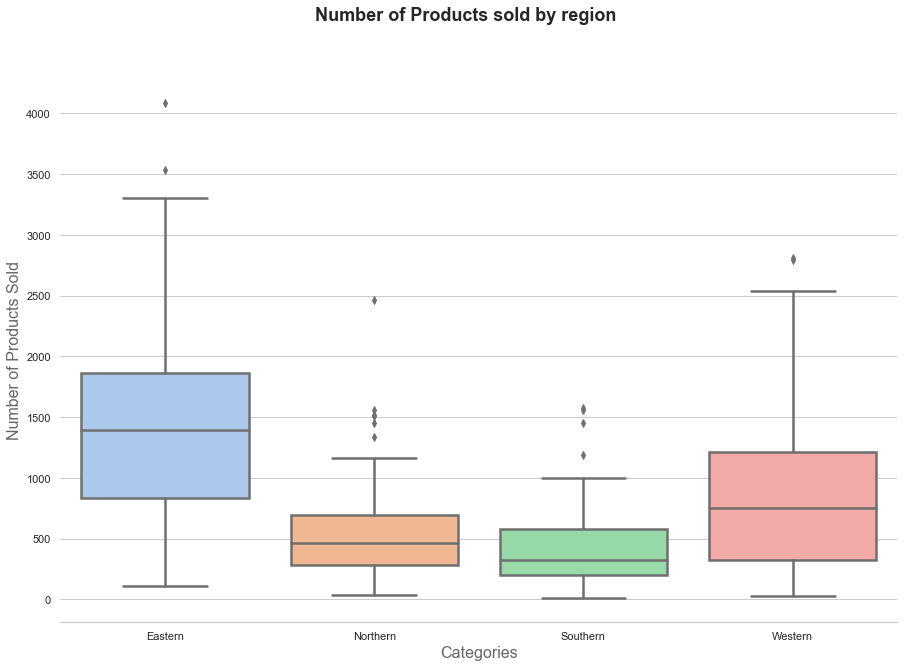

In [21]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

f, ax = plt.subplots(figsize=(15, 10))

# Draw a nested violinplot and split the violins for easier comparison
sns.boxplot(x="regions", y="quantity", data=h3, linewidth=2.5)
sns.despine(left=True)

f.suptitle('Number of Products sold by region', fontsize=18, fontweight='bold')
ax.set_xlabel("Categories",size = 16,alpha=0.7)
ax.set_ylabel("Number of Products Sold",size = 16,alpha=0.7)

Text(0,0.5,'Income')

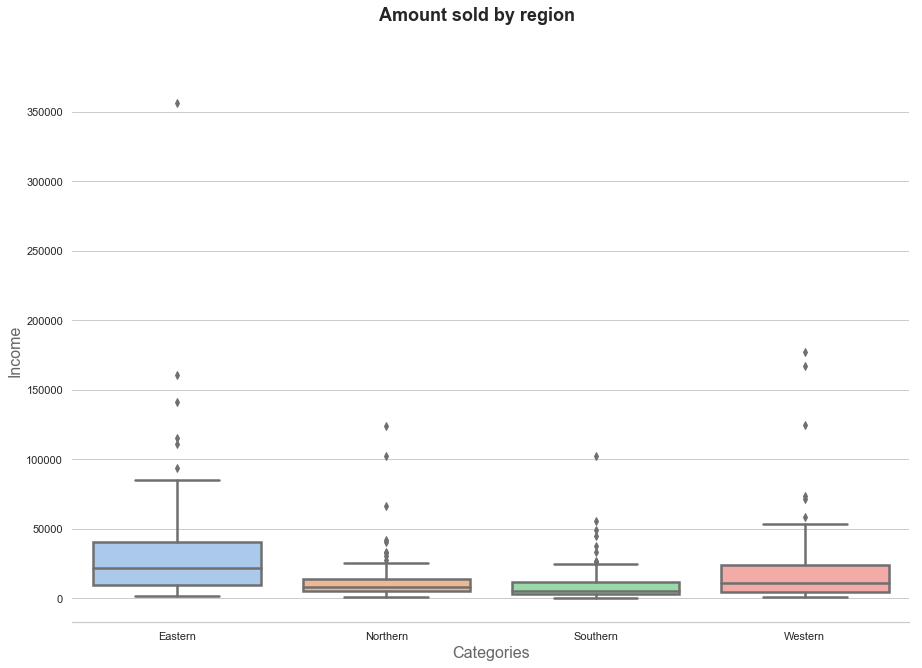

In [137]:
f, ax = plt.subplots(figsize=(15, 10))

# Draw a nested violinplot and split the violins for easier comparison
sns.boxplot(x="regions", y="Total", data=h3, linewidth=2.5)
sns.despine(left=True)

f.suptitle('Amount sold by region', fontsize=18, fontweight='bold')
ax.set_xlabel("Categories",size = 16,alpha=0.7)
ax.set_ylabel("Income",size = 16,alpha=0.7)

In [138]:
h3.groupby('regions').mean()

,product,quantity,unit_price,discount,Total
regions,,,,,
Eastern,39.000000,1411.103896,1540.943247,3.112727,35457.117006
Northern,39.200000,564.560000,648.245333,1.460000,13981.407673
Southern,39.905405,424.432432,472.887568,0.862162,10962.856378
Western,39.600000,855.666667,884.665333,2.336667,21536.639967


## 3. Test using an Experiment

I will use tukey tests to compare the means of the various product categories and regions. I will first compare regions amongst themselves and then categories within regions.

### Test 1

In [22]:
mc3 = MultiComparison(h3['quantity'], h3['regions']) 
result3 = mc3.tukeyhsd()

print(result3)
print(mc3.groupsunique)

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
 group1   group2   meandiff   lower      upper   reject
-------------------------------------------------------
Eastern  Northern -846.5439 -1095.5163 -597.5715  True 
Eastern  Southern -986.6715 -1236.4946 -736.8484  True 
Eastern  Western  -555.4372 -804.4096  -306.4649  True 
Northern Southern -140.1276 -391.5778   111.3226 False 
Northern Western   291.1067  40.5017    541.7117  True 
Southern Western   431.2342  179.784    682.6844  True 
-------------------------------------------------------
['Eastern' 'Northern' 'Southern' 'Western']


### Test 2

In [26]:
mc3 = MultiComparison(h3['Total'], h3['regions']) 
result3 = mc3.tukeyhsd()

print(result3)
print(mc3.groupsunique)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
 group1   group2    meandiff     lower       upper    reject
------------------------------------------------------------
Eastern  Northern -21475.7093 -34907.9546  -8043.4641  True 
Eastern  Southern -24494.2606 -37972.4038 -11016.1175  True 
Eastern  Western   -13920.477 -27352.7223  -488.2318   True 
Northern Southern  -3018.5513 -16584.4777  10547.3751 False 
Northern Western   7555.2323   -5965.0942  21075.5588 False 
Southern Western   10573.7836  -2992.1428  24139.7099 False 
------------------------------------------------------------
['Eastern' 'Northern' 'Southern' 'Western']


### Test 3

In [57]:
mc3 = MultiComparison(h3['quantity'], h3['categories']) 
result3 = mc3.tukeyhsd()

print(result3)
print(mc3.groupsunique)

         Multiple Comparison of Means - Tukey HSD,FWER=0.05        
    group1         group2      meandiff   lower      upper   reject
-------------------------------------------------------------------
  Beverages      Condiments   -367.1458  -807.284   72.9923  False 
  Beverages     Confections   -215.4558 -641.5931   210.6814 False 
  Beverages    Dairy Products  191.6042 -259.8699   643.0782 False 
  Beverages    Grains/Cereals -189.4315 -690.9065   312.0434 False 
  Beverages     Meat/Poultry   -80.6458 -607.8539   446.5623 False 
  Beverages       Produce     -250.6958 -811.9517    310.56  False 
  Beverages       Seafood      -198.449 -631.1963   234.2982 False 
  Condiments    Confections     151.69  -284.2178   587.5978 False 
  Condiments   Dairy Products   558.75   98.0424   1019.4576  True 
  Condiments   Grains/Cereals  177.7143 -332.0894   687.518  False 
  Condiments    Meat/Poultry    286.5   -248.6365   821.6365 False 
  Condiments      Produce       116.45  -452.259

### Test 4

In [58]:
mc3 = MultiComparison(h3['Total'], h3['categories']) 
result3 = mc3.tukeyhsd()

print(result3)
print(mc3.groupsunique)

           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
    group1         group2       meandiff     lower      upper    reject
-----------------------------------------------------------------------
  Beverages      Condiments   -15763.3779 -36534.4963 5007.7405  False 
  Beverages     Confections   -11826.6499 -31937.0329 8283.7332  False 
  Beverages    Dairy Products  2938.2501  -18367.8345 24244.3347 False 
  Beverages    Grains/Cereals -11690.3988 -35356.1386 11975.3411 False 
  Beverages     Meat/Poultry   9099.5096  -15780.6369 33979.6561 False 
  Beverages       Produce      -3964.6281 -30451.5667 22522.3105 False 
  Beverages       Seafood     -14962.3869 -35384.7117  5459.938  False 
  Condiments    Confections     3936.728  -16634.7507 24508.2068 False 
  Condiments   Dairy Products  18701.628   -3040.2089 40443.465  False 
  Condiments   Grains/Cereals  4072.9791   -19985.813 28131.7712 False 
  Condiments    Meat/Poultry   24862.8875  -391.4175  50117.1926

## 4. Analize Data and Draw conclusions

**The Eastern Region is the strongest, followed by the Western Region in both sales and number of products sold. There is however no leading category.**

- The Eastern region sells more product than the other three regions. The Western region also sells more than both the Southern and Northern regions. There is no significant difference between the Southern and Northern regions.

- The Eastern region has more in sales than the other three regions but there is no significant difference between the other regions. 

- There is no outstanding significant categories in terms of either sales or product.

Based on this data, I would suggest to continue to support the eastern region most with an emphasis on sales in the western region as they are already selling more product. 

----
# Hypothesis 4

## 1. Ask a Question

The first question that I am trying to answer is the following:

>*Is there a difference in the number of imports and domestic products that customers purchase? Which products are more lucrative?

or

>*Is there a significant difference in the mean products and sales sold domestically vs imported?

### Null Hypothesis:
**$H0: \mu_0  =  \mu_A$**

### Alternative Hypothesis:
**$HA: \mu_0  !=  \mu_A$**

I will run a welch's t-test to test the difference between products sold domestically vs. imported. The significance value I will use is a value of p=0.05. 

## 2. Do Background Research

In [29]:
df['Supplier'][:5]

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


In [31]:
h4 = pd.read_sql_query('''SELECT p.id as product, od.quantity quantity, od.unitprice unit_price, 
                            od.discount discount, s.id supplier, s.region supp_region, 
                            c.id customer, c.region cust_region
                            FROM supplier s
                            JOIN product p  ON s.id = p.supplierid 
                            JOIN orderdetail od ON p.Id = od.productId
                            JOIN [order] o ON od.OrderId = o.Id
                            JOIN customer c ON o.customerid = c.id
                            ;''', con)
h4.head(5)

2019-01-31 22:21:31,811 INFO sqlalchemy.engine.base.Engine SELECT p.id as product, od.quantity quantity, od.unitprice unit_price, 
                            od.discount discount, s.id supplier, s.region supp_region, 
                            c.id customer, c.region cust_region
                            FROM supplier s
                            JOIN product p  ON s.id = p.supplierid 
                            JOIN orderdetail od ON p.Id = od.productId
                            JOIN [order] o ON od.OrderId = o.Id
                            JOIN customer c ON o.customerid = c.id
                            ;
2019-01-31 22:21:31,813 INFO sqlalchemy.engine.base.Engine ()


,product,quantity,unit_price,discount,supplier,supp_region,customer,cust_region
0,11,12,14.0,0.0,5,Southern Europe,VINET,Western Europe
1,42,10,9.8,0.0,20,South-East Asia,VINET,Western Europe
2,72,5,34.8,0.0,14,Southern Europe,VINET,Western Europe
3,14,9,18.6,0.0,6,Eastern Asia,TOMSP,Western Europe
4,51,40,42.4,0.0,24,NSW,TOMSP,Western Europe


In [32]:
h4['total'] = h4['quantity'] * (h4['unit_price']-(h4['unit_price']*h4['discount']))

domestic =  h4.loc[h4['supp_region'] == h4['cust_region']]
imports =  h4.loc[h4['supp_region'] != h4['cust_region']]

domestic['imp_dom'] = 'domestic'
imports['imp_dom'] = 'imported'

h4_imp_dom = pd.concat([imports,domestic])
h4_imp_dom.head(10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,product,quantity,unit_price,discount,supplier,supp_region,customer,cust_region,total,imp_dom
0,11,12,14.0,0.00,5,Southern Europe,VINET,Western Europe,168.00,imported
1,42,10,9.8,0.00,20,South-East Asia,VINET,Western Europe,98.00,imported
2,72,5,34.8,0.00,14,Southern Europe,VINET,Western Europe,174.00,imported
3,14,9,18.6,0.00,6,Eastern Asia,TOMSP,Western Europe,167.40,imported
4,51,40,42.4,0.00,24,NSW,TOMSP,Western Europe,1696.00,imported
5,41,10,7.7,0.00,19,North America,HANAR,South America,77.00,imported
6,51,35,42.4,0.15,24,NSW,HANAR,South America,1261.40,imported
7,65,15,16.8,0.15,2,North America,HANAR,South America,214.20,imported
8,22,6,16.8,0.05,9,Northern Europe,VICTE,Western Europe,95.76,imported
9,57,15,15.6,0.05,26,Southern Europe,VICTE,Western Europe,222.30,imported


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


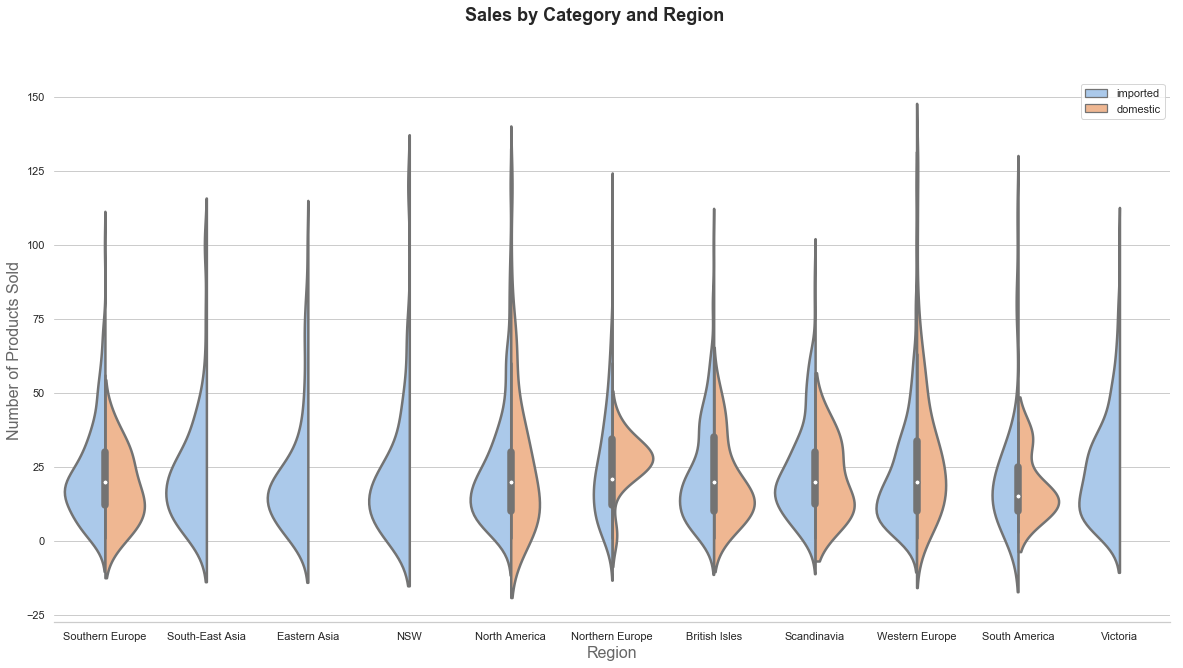

In [111]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

f, ax = plt.subplots(figsize=(20, 10))

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="supp_region", y="quantity", hue='imp_dom', split=True, data=h4_imp_dom, linewidth=2.5)
sns.despine(left=True)

f.suptitle('Sales by Category and Region', fontsize=18, fontweight='bold')
ax.set_xlabel("Region",size = 16,alpha=0.7)
ax.set_ylabel("Number of Products Sold",size = 16,alpha=0.7)
plt.legend(loc='upper right')

In [94]:
print('Statistics for Imports:')
print('Sample Size: ',len(imports['total']))
print('Mean: ',np.mean(imports['total']))
print('Variance: ',np.var(imports['total']))
print('\n')
print('Statistics for Domestic:')
print('Sample Size: ',len(domestic['total']))
print('Mean: ',np.mean(domestic['total']))
print('Variance: ',np.var(domestic['total']))


# Levene Test for testing homogeneity of variances
from scipy import stats
stats.levene(imports['total'],domestic['total'])

Statistics for Imports:
Sample Size:  1780
Mean:  540.5980019662924
Variance:  749084.9844669156


Statistics for Domestic:
Sample Size:  298
Mean:  891.6477214765101
Variance:  2051137.4728267768


LeveneResult(statistic=30.061705929610266, pvalue=4.694649311730662e-08)

In [33]:
print('Statistics for Imports:')
print('Sample Size: ',len(imports['product']))
print('Mean: ',np.mean(imports['product']))
print('Variance: ',np.var(imports['product']))
print('\n')
print('Statistics for Domestic:')
print('Sample Size: ',len(domestic['product']))
print('Mean: ',np.mean(domestic['product']))
print('Variance: ',np.var(domestic['product']))

print()

# Levene Test for testing homogeneity of variances
from scipy import stats
stats.levene(imports['product'],domestic['product'])

Statistics for Imports:
Sample Size:  1780
Mean:  40.32865168539326
Variance:  495.5577184067679


Statistics for Domestic:
Sample Size:  298
Mean:  44.33892617449664
Variance:  446.86835052475124



LeveneResult(statistic=0.9818929198646213, pvalue=0.32184739873191415)

## 3. Test with an Experiment

There are a few assumption we need to make in order to be able to compare the means:

1. **Data is independent**

We can assume the data is independant because we are working with individual products and discounts. 

2. **Data is collected randomly**

We can assume random data.

3. **The data is approximately normally distributed**

Base on the violin graph about the data seems to be approximately normally distributed. 

4. **Data sample size and variance are similar**

Based on the levene test above we can assume homogeneity of variance for our numbe of product data but cannot assume homogeneity of variance for our total sales data.

### Test 1

In [60]:
print(stats.ttest_ind(imports['product'], domestic['product']))

print("Cohen's d: ",Cohen_d(imports['product'], domestic['product']))

Ttest_indResult(statistic=-2.897307583826179, pvalue=0.0038032368139547285)
Cohen's d:  -0.181345374098745


### Test 2

In [61]:
print(stats.ttest_ind(imports['total'], domestic['total'],equal_var=False))
print("Cohen's d: ",Cohen_d(imports['total'], domestic['total']))

Ttest_indResult(statistic=-4.101076782997389, pvalue=5.169912347687213e-05)
Cohen's d:  -0.3626284182039817


## 4. Analize Data and Draw conclusions

**Develop relationships with more domestic partners and push domestic suppliers**

- The t-test comparing the mean number of imports sold (40.32) vs. domestic products (44.33) was significant. $t=-2.897,p=0.0038$

- The t-test comparing the mean sales of imports (540.59) vs. domestic products (891.64) was significant. $t=-4.101,p=5.1699e-05$

Based on this analysis I would encourage Northwind trading co. to invest in domestic suppliers. While most of the business is done with imports 84%, when customers buy domestically, they purchace more products on average and spend more money. 

